In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import Data

In [2]:
import pandas as pd
import numpy as np
import calendar as cal
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [3]:
path1 = "/content/drive/MyDrive/Data Sets/XYZ Kicks/pageviews.csv"
path2 = "/content/drive/MyDrive/Data Sets/XYZ Kicks/funnel.csv"

df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)
# Table Relationship: IP, Timestamps

## Data Preparation

In [4]:
pv_df = df1
funnel_df = df2

In [5]:
datasets = [pv_df, funnel_df]
for x in datasets:
  print(x.shape)

(387477, 11)
(8560, 10)


##### Data Types

In [6]:
pv_df.info()
funnel_df.info()

# DType Changes:
# # timestamp -> datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387477 entries, 0 to 387476
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   website_visitor_id  387477 non-null  int64 
 1   session_id          387477 non-null  int64 
 2   timestamp           387477 non-null  object
 3   country             387477 non-null  object
 4   region              387477 non-null  object
 5   ip                  387477 non-null  object
 6   marketing_source    119490 non-null  object
 7   landing_page        387477 non-null  object
 8   previous_page       387477 non-null  object
 9   device_type         387477 non-null  object
 10  browser_type        387477 non-null  object
dtypes: int64(2), object(9)
memory usage: 32.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8560 entries, 0 to 8559
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                       

In [7]:
#Convert timestamp columns -> datetime
pv_df['timestamp'] = pd.to_datetime(pv_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f%z', errors='coerce')
funnel_df['first_cart_item_ts'] = pd.to_datetime(funnel_df['first_cart_item_ts'], format='%Y-%m-%d %H:%M:%S.%f%z', errors='coerce')
funnel_df['first_purchase_ts'] = pd.to_datetime(funnel_df['first_purchase_ts'], format='%Y-%m-%d %H:%M:%S.%f%z', errors='coerce')
funnel_df['second_purchase_ts'] = pd.to_datetime(funnel_df['second_purchase_ts'], format='%Y-%m-%d %H:%M:%S.%f%z', errors='coerce')

## Data Cleaning

##### Missing Values

In [8]:
print(f'Pageviews Null Values: \n{pv_df.isnull().sum()}')
print(f'\nFunnel Null Values: \n{funnel_df.isnull().sum()}')
# issue with 'timestamp' nulls in pv_df, will drop rows
# marketing_source is not required field, will contain nulls
# first/second_purchase_ts apart of sales funnel, will have nulls

Pageviews Null Values: 
website_visitor_id         0
session_id                 0
timestamp                333
country                    0
region                     0
ip                         0
marketing_source      267987
landing_page               0
previous_page              0
device_type                0
browser_type               0
dtype: int64

Funnel Null Values: 
customer_id                         0
frequency_of_online_shopping        0
shoe_type                           0
primary_footwear_use                0
shipping_preference                 0
eligible_for_express_shipping       0
ip_address                          0
first_cart_item_ts                  5
first_purchase_ts                3540
second_purchase_ts               5310
dtype: int64


In [9]:
# drop rows w/ 'timestamp' nulls (NaT)
pv_df = pv_df.loc[pv_df['timestamp'].notnull()]

##### Unique Values

In [10]:
datasets = [pv_df, funnel_df]
df_name = ['pv_df', 'funnel_df']
for x in range(len(datasets)):
  columns = list(datasets[x].columns)
  print(f'\n{df_name[x]}:')
  for y in columns:
    print(f'{y}: {len(datasets[x][y].unique())} types')
# customers are unique and each has first_cart_time


pv_df:
website_visitor_id: 72566 types
session_id: 182969 types
timestamp: 383712 types
country: 5 types
region: 41 types
ip: 71730 types
marketing_source: 23 types
landing_page: 85 types
previous_page: 85 types
device_type: 3 types
browser_type: 9 types

funnel_df:
customer_id: 8560 types
frequency_of_online_shopping: 3 types
shoe_type: 4 types
primary_footwear_use: 3 types
shipping_preference: 4 types
eligible_for_express_shipping: 2 types
ip_address: 8560 types
first_cart_item_ts: 8556 types
first_purchase_ts: 5021 types
second_purchase_ts: 3251 types


##### Duplicates

In [11]:
print('Number of Duplicates: \nPageviews Dataset - '+ str(pv_df.duplicated().sum())
                          + '\nFunnel Dataset - '+ str(funnel_df.duplicated().sum()))
#investigate duplicates in PV

Number of Duplicates: 
Pageviews Dataset - 3406
Funnel Dataset - 0


In [12]:
pv_df = pv_df.drop_duplicates()

### **Table Relationship Assumptions**
* Every customer has visited the page and has data collected in *pageviews* table
* IP Address present on both tables

**Direction:**
* Define effectiveness metrics by each table separately
* Avoid visitor -> customer lineage assumptions

##### Issue 1: Missing Customers in Pageviews Table

In [13]:
col1 = ['website_visitor_id','session_id','timestamp','ip','customer_id', 'ip_address','first_cart_item_ts']
assump_df = pd.merge(pv_df,funnel_df, left_on='ip', right_on='ip_address', how='outer')
missing_pv_customers = assump_df.loc[(assump_df['ip'] != assump_df['ip_address']) & (assump_df['ip_address'].notna()), col1]
missing_pv_customers.head()

,website_visitor_id,session_id,timestamp,ip,customer_id,ip_address,first_cart_item_ts
383738,NaN,NaN,NaT,NaN,31e4e48a-9c8f-43aa-97a4-6d1ae042fe64,737af56065e4dbc976027d8389be4a21ad062259ea993b...,2017-03-04 15:13:23.228000+00:00
383739,NaN,NaN,NaT,NaN,75dfb900-e4aa-4857-bd08-7869286f81d6,1ff82e3b972c9b0fa80fdbd028b6e01b733677ae22bd7e...,2018-12-18 20:26:06.782000+00:00
383740,NaN,NaN,NaT,NaN,e5234c2e-3690-401f-98bb-5f253dd96d54,82304182d269c356414b55e565b74c1db98ebc40a45714...,2018-06-09 14:44:27.765000+00:00
383741,NaN,NaN,NaT,NaN,b095dfb5-cc57-4da5-b50b-535929ddc6a4,fc7911dafca7e9b31b315382334190f074e03a916638e2...,2018-02-16 18:43:48.735000+00:00
383742,NaN,NaN,NaT,NaN,3df19a44-06f3-4f38-bb57-be2ae62213b6,7560afbc16e958edf3de6ea4251b447acf102a270187cd...,2016-12-06 15:02:58.625000+00:00


In [14]:
# Made assumption that ALL customers are linked pageviews table (via IP address)

assump_df = pd.merge(pv_df,funnel_df, left_on='ip', right_on='ip_address', how='outer')
missing_pv_customers = assump_df.loc[(assump_df['ip'] != assump_df['ip_address']) & (assump_df['ip_address'].notna())]
non_pv_customers = missing_pv_customers['customer_id'].nunique()
customer_pct_missing = non_pv_customers / assump_df['customer_id'].nunique() * 100
print(f'Number of customers NOT linked to pageviews table (via IP): {non_pv_customers}')
print(f'% customers NOT linked to pageviews table (via IP): {customer_pct_missing:.2f}%')

#Sizeable impact, affecting correlated analysis
# Ex: visitor to purchase conversion rate (missing purchases)

Number of customers NOT linked to pageviews table (via IP): 3282
% customers NOT linked to pageviews table (via IP): 38.34%


##### Issue 2: IP Relationship

In [15]:
# IP Timestamp Disconnect (Pageviews vs Funnel) Example - Website_Visitor_ID: 6744710523682427

#Earliest PV timestamp for each visitor_id
first_visitor_ts = assump_df.loc[assump_df['first_purchase_ts'].notna()].groupby('website_visitor_id')['timestamp'].min().reset_index()

#Rename + Merge Column to Dataframe
first_visitor_ts.rename(columns={'timestamp':'first_ts'}, inplace=True)
first_visitor_df = pd.merge(assump_df,first_visitor_ts, on='website_visitor_id', how='inner')

# Time Difference Between Earliest PV and First Purchase
first_visitor_df['first_pv_to_purchase'] = (first_visitor_df['first_purchase_ts'] - first_visitor_df['first_ts'])#.dt.total_seconds() / 3600

col2 = ['website_visitor_id','session_id','timestamp','ip','customer_id','first_cart_item_ts','first_purchase_ts','first_pv_to_purchase']
first_visitor_df.loc[first_visitor_df['website_visitor_id'] == 6744710523682427, col2]
# Shows earliest pageview (6/13/21) is after first purchase (3/24/18), emphasizing disconnect of IP relationship

,website_visitor_id,session_id,timestamp,ip,customer_id,first_cart_item_ts,first_purchase_ts,first_pv_to_purchase
77565,6.744711e+15,2.182010e+15,2021-06-13 19:18:28.674000+00:00,3968928384a7b6e4eae1e90821da6834b2ecdaa40adabd...,272b9603-f731-40da-92d2-9c21afc364d6,2018-03-23 12:54:56.037000+00:00,2018-03-24 07:17:56.037000+00:00,-1178 days +11:59:27.363000


In [16]:
neg_ts = first_visitor_df.loc[first_visitor_df['first_pv_to_purchase'].dt.total_seconds() / 3600 < 0, col2]
neg_ip_cnt = len(neg_ts)
neg_ts_pct = len(neg_ts)/assump_df['customer_id'].nunique() * 100

print(f'Number of customers w/ negative visitor to cart timestamp (via IP): {neg_ip_cnt}')
print(f'% customers  negative visitor to cart timestamp (via IP): {neg_ts_pct:.2f}%')

# Sizeable impact, showing disconnect via IP. Need to establish IP relationship

Number of customers w/ negative visitor to cart timestamp (via IP): 1065
% customers  negative visitor to cart timestamp (via IP): 12.44%


##### Issue 3: Pageview Data Integrity

In [17]:
# Pageviews Data Integrity
#(After duplicate dropped, identified views (rows) w/ same session_id + timestamp but multiple landing_page)

#Example - website_visitor_id: 640922342375145 | session_id: 3395648995646806 | timestamp: 2016-10-11 15:36:26.249

pv_df.loc[pv_df['timestamp'].duplicated(False)].sort_values(['timestamp','session_id']).head(6)

,website_visitor_id,session_id,timestamp,country,region,ip,marketing_source,landing_page,previous_page,device_type,browser_type
4670,640922342375145,3395648995646806,2016-10-11 15:36:26.249000+00:00,Country A,Region P,e0cda1544f89d1ce5261d4cd36b9bfb2193c32639944d1...,NaN,/,/customer-reviews-of-xyz-kicks,Tablet,Chrome
34092,640922342375145,3395648995646806,2016-10-11 15:36:26.249000+00:00,Country A,Region P,e0cda1544f89d1ce5261d4cd36b9bfb2193c32639944d1...,NaN,/customer-reviews-of-xyz-kicks,/other-page,Tablet,Chrome
181863,4845341143424707,2610058873840194,2017-03-05 19:24:46.633000+00:00,Country A,Region HH,79e7a5487b5ed7074c3e91218aa3715dcd80375afddb93...,NaN,/work-at-xyz,/work-at-xyz,Mobile,Safari
309620,4845341143424707,2610058873840194,2017-03-05 19:24:46.633000+00:00,Country A,Region HH,79e7a5487b5ed7074c3e91218aa3715dcd80375afddb93...,NaN,/work-at-xyz,/,Mobile,Safari
138854,7027599561003973,6663291153391107,2017-05-09 17:02:39.197000+00:00,Country A,Region FF,269a9dc1ecd809fe7fc4db71c5fb88ee761e75c20d0254...,source D,/tell-me-why-i-should-choose-xyz,/xyz-help,Mobile,Safari
359762,7027599561003973,6663291153391107,2017-05-09 17:02:39.197000+00:00,Country A,Region FF,269a9dc1ecd809fe7fc4db71c5fb88ee761e75c20d0254...,source D,/xyz-help,/optimal-shoe-quiz,Mobile,Safari


In [18]:
dup_pv_cnt = len(pv_df.loc[pv_df['timestamp'].duplicated()].sort_values(['session_id','timestamp']))
dup_pv_pct = dup_pv_cnt/len(pv_df) * 100

print(f'Number of duplicate pageviews w/ multiple landing pages (via session_id, timestamp): {dup_pv_cnt}')
print(f'% duplicate pageviews (via session_id, timestamp): {dup_pv_pct:.2f}%')

# Small impact. Assuming web analytics/DE issue. Begs question, how is a page view truly defined? (concat method?)

Number of duplicate pageviews w/ multiple landing pages (via session_id, timestamp): 26
% duplicate pageviews (via session_id, timestamp): 0.01%


## Transformation

##### **Effectiveness**

Effectiveness = attract and retain high-quality customers who demonstrate the following behaviors:

* Engagement: Customers actively interact with the website, browse product offerings, and explore web content, indicating genuine interest in XYZ Kicks' offerings.

* Conversion: Customers make a first-time purchase, indicating a successful conversion from website visitor to paying customer.

* Retention: Customers who make a first purchase are retained over time and potentially make repeat purchases, indicating satisfaction with the product/ser vice and loyalty to the brand.

##### **Key Metrics**
  * Pageviews Count (PV)
  * Session Duration (PV)
  * Conversion Rate (Cart - Purchase) (F)
  * Retention Rate (First - Second Purchase) (F)

##### **Segmentation**
  * Time
     * Historical (Date)
     * Seasonal (Month, Peak Hour, DOW)
  * Categorical (PV)
    * Marketing Source
    * Country Type
    * Region Type
    * Device Type
    * Browser Type
  * Categorical (F)
    * frequency_of_online_shopping
    * shoe_type
    * primary_footwear_use
    * shipping_preference
    * eligible_for_express_shipping

##### **Pageviews Table**

In [19]:
#Pageviews Transformations
pv_df['date'] = pv_df['timestamp'].dt.date
pv_df['month_year'] = pv_df['timestamp'].dt.strftime('%Y-%m')
pv_df['month'] = pv_df['timestamp'].dt.month
pv_df['dow'] = pv_df['timestamp'].dt.dayofweek
pv_df['hour'] = pv_df['timestamp'].dt.hour

# Primary Key + Sequential ID -> Pageview ID
pv_df.sort_values(by=['website_visitor_id', 'session_id', 'timestamp'], inplace=True)
pv_df['sequential_id'] = pv_df.groupby(['website_visitor_id', 'session_id', 'timestamp']).cumcount() + 1
pv_df['pageview_id'] = pv_df['website_visitor_id'].astype(str) + '_' + \
                              pv_df['session_id'].astype(str) + '_' + \
                              pv_df['timestamp'].astype(str) + '_' + \
                              pv_df['sequential_id'].astype(str)
pv_df = pv_df[['pageview_id'] + [col for col in pv_df.columns if col != 'pageview_id']]

# Session Start/End Times
pv_df.sort_values(by=['session_id', 'timestamp'], inplace=True)
sessions = {}

for idx, row in pv_df.iterrows():
    session_id = row['session_id']
    timestamp = row['timestamp']
    if session_id not in sessions:
        sessions[session_id] = {'session_start_time': timestamp, 'session_end_time': timestamp}
    else:
        sessions[session_id]['session_end_time'] = max(sessions[session_id]['session_end_time'], timestamp)

session_info = pd.DataFrame.from_dict(sessions, orient='index').reset_index()
session_info.rename(columns={'index': 'session_id'}, inplace=True)
pv_df = pd.merge(pv_df, session_info, on='session_id', how='inner')
pv_df['session_duration'] = (pv_df['session_end_time'] - pv_df['session_start_time']).dt.total_seconds()
cols = pv_df.columns.tolist()
cols = cols[:4] + cols[-3:] + cols[4:-3]
pv_df = pv_df[cols]
pv_df.head()

,pageview_id,website_visitor_id,session_id,timestamp,session_start_time,session_end_time,session_duration,country,region,ip,marketing_source,landing_page,previous_page,device_type,browser_type,date,month_year,month,dow,hour,sequential_id
0,981716907791385_37716715015_2018-12-15 15:55:1...,981716907791385,37716715015,2018-12-15 15:55:11.122000+00:00,2018-12-15 15:55:11.122000+00:00,2018-12-15 16:05:47.992000+00:00,636.870,Country A,Region D,d6db89d76469222d6a6e57ebaa16906a0b5f3942d2eba3...,source D,/,/other-page,Desktop,Chrome,2018-12-15,2018-12,12,5,15,1
1,981716907791385_37716715015_2018-12-15 16:05:4...,981716907791385,37716715015,2018-12-15 16:05:47.992000+00:00,2018-12-15 15:55:11.122000+00:00,2018-12-15 16:05:47.992000+00:00,636.870,Country A,Region D,d6db89d76469222d6a6e57ebaa16906a0b5f3942d2eba3...,source D,/,/other-page,Desktop,Chrome,2018-12-15,2018-12,12,5,16,1
2,333423403452398_124873650914_2023-08-06 23:07:...,333423403452398,124873650914,2023-08-06 23:07:01.880000+00:00,2023-08-06 23:07:01.880000+00:00,2023-08-06 23:12:24.486000+00:00,322.606,Country A,Region B,4ae531632facd462d65967c63cc0f8190e5dc02fad996f...,NaN,/,/other-page,Mobile,Chrome,2023-08-06,2023-08,8,6,23,1
3,333423403452398_124873650914_2023-08-06 23:12:...,333423403452398,124873650914,2023-08-06 23:12:24.486000+00:00,2023-08-06 23:07:01.880000+00:00,2023-08-06 23:12:24.486000+00:00,322.606,Country A,Region B,4ae531632facd462d65967c63cc0f8190e5dc02fad996f...,NaN,/,/other-page,Mobile,Chrome,2023-08-06,2023-08,8,6,23,1
4,413380430341218_208653614104_2020-08-20 20:21:...,413380430341218,208653614104,2020-08-20 20:21:24.747000+00:00,2020-08-20 20:21:24.747000+00:00,2020-08-20 20:40:02.979000+00:00,1118.232,Country A,Region L,2471c2c9bfe9093905e7f3be613d1403c8a33a0a8799f0...,NaN,/work-at-xyz,/other-page,Desktop,Chrome,2020-08-20,2020-08,8,3,20,1


##### **Funnel Table**

In [20]:
#Funnel Transformations
funnel_df['date'] = funnel_df['first_purchase_ts'].dt.date
funnel_df['month_year'] = funnel_df['first_purchase_ts'].dt.strftime('%Y-%m')
funnel_df['month_year_cart'] = funnel_df['first_cart_item_ts'].dt.strftime('%Y-%m')
funnel_df['month'] = funnel_df['first_purchase_ts'].dt.month
funnel_df['month_cart'] = funnel_df['first_cart_item_ts'].dt.month
funnel_df['dow'] = funnel_df['first_purchase_ts'].dt.dayofweek
funnel_df['hour'] = funnel_df['first_purchase_ts'].dt.hour
funnel_df['cart_to_purchase_duration'] = (funnel_df['first_purchase_ts'] - funnel_df['first_cart_item_ts']).dt.total_seconds()
funnel_df['first_to_second_purchase'] = (funnel_df['second_purchase_ts'] - funnel_df['first_purchase_ts']).dt.total_seconds()
funnel_df.head()

,customer_id,frequency_of_online_shopping,shoe_type,primary_footwear_use,shipping_preference,eligible_for_express_shipping,ip_address,first_cart_item_ts,first_purchase_ts,second_purchase_ts,date,month_year,month_year_cart,month,month_cart,dow,hour,cart_to_purchase_duration,first_to_second_purchase
0,1a397fa3-c8dd-4eb7-aac0-e925abc461a0,rarely,sneakers,fitness,free_ground_shipping,1.0,c88ef8e5874f1eb037b600eb6367e62bfe37f359ff38d3...,2017-03-01 11:18:10.024000+00:00,NaT,NaT,NaT,NaN,2017-03,NaN,3.0,NaN,NaN,NaN,NaN
1,65fb7596-8f5d-49f3-b45d-7df0af211e70,frequently,sneakers,casual_wear,free_ground_shipping,0.0,ec12bf59401a5e5772f4cbff7552dc142a82e8166363ad...,2020-07-11 19:16:47.479000+00:00,2020-07-14 17:58:47.479000+00:00,2020-08-04 16:27:47.479000+00:00,2020-07-14,2020-07,2020-07,7.0,7.0,1.0,17.0,254520.0,1808940.0
2,921be970-d28f-4ea5-917c-dcc250320522,frequently,sneakers,fitness,free_ground_shipping,0.0,e970b6e29881ecd7d87fc05bfaf21e23383909dab7cf19...,2021-04-17 08:40:34.940000+00:00,2021-04-17 19:59:34.940000+00:00,2021-06-26 02:20:34.940000+00:00,2021-04-17,2021-04,2021-04,4.0,4.0,5.0,19.0,40740.0,5984460.0
3,c9fb33a5-eb58-4161-b441-29e12209cd6b,frequently,boots,casual_wear,free_ground_shipping,0.0,c2d824b5c07fbd9ca08e92c32e59ac502e3d9564eb0b62...,2019-09-18 17:47:03.360000+00:00,2019-09-24 18:13:03.360000+00:00,2019-09-24 23:44:03.360000+00:00,2019-09-24,2019-09,2019-09,9.0,9.0,1.0,18.0,519960.0,19860.0
4,cbcf0bcd-304f-4eba-a8ed-3fd055afa75c,frequently,sneakers,casual_wear,free_ground_shipping,0.0,7146a3b6a7c4287eb1e170ac5b17503aa8fa67867938df...,2019-07-26 12:13:57.649000+00:00,2019-07-27 01:16:57.649000+00:00,2019-08-02 13:03:57.649000+00:00,2019-07-27,2019-07,2019-07,7.0,7.0,5.0,1.0,46980.0,560820.0


## Summary Statistics

### Pageviews Table

In [21]:
# Excluding Outliers Function (For Duration Metrics)
def outlier_removal(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - (1.5 * IQR)
  upper_bound = Q3 + (1.5 * IQR)
  return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Axis Generation (Time)
pv_start_dt = pv_df['timestamp'].min()
pv_end_dt = pv_df['timestamp'].max()
qtr = (pd.date_range(pv_start_dt, pv_end_dt, freq='QS').strftime('%Y-%m').tolist())
years = (pd.date_range(pv_start_dt, pv_end_dt, freq='YS').strftime('%Y-%m').tolist())

# Segment Categories
seg = ['country', 'region', 'marketing_source', 'device_type', 'browser_type']

#### **Pageviews via Time**

In [22]:
time_groups = ['month', 'dow', 'hour']
time_pv_share = {}
for x in range(len(time_groups)):
  time_pv_share["{0}_pv".format(time_groups[x])] = pv_df.groupby(time_groups[x])['pageview_id'].count().reset_index()
  tot_pv = time_pv_share["{0}_pv".format(time_groups[x])]['pageview_id'].sum()
  time_pv_share["{0}_pv".format(time_groups[x])]['pv_share (%)'] = round(time_pv_share["{0}_pv".format(time_groups[x])]['pageview_id']/tot_pv*100, 2)
  time_pv_share["{0}_pv".format(time_groups[x])].rename(columns={'pageview_id': 'n_pageviews'}, inplace=True)
  if time_groups[x] == 'dow':
    time_pv_share["{0}_pv".format(time_groups[x])]['dow'] = time_pv_share["{0}_pv".format(time_groups[x])]['dow'].astype(int)
    time_pv_share["{0}_pv".format(time_groups[x])]['dow'] = time_pv_share["{0}_pv".format(time_groups[x])]['dow'].apply(lambda y: cal.day_name[y])
pv_time_groups = list(time_pv_share.keys())

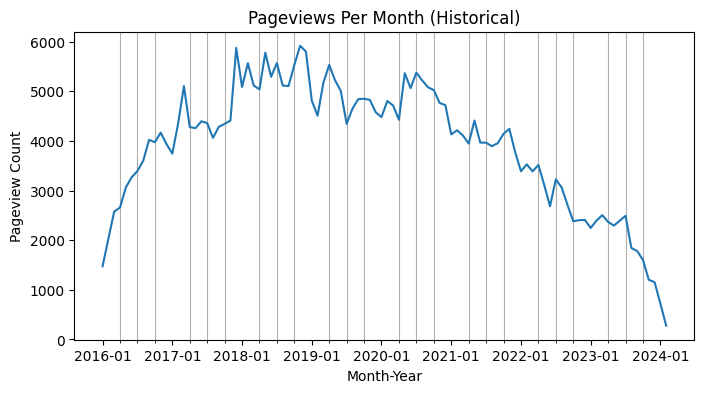

In [23]:
monthly_pv = pv_df.groupby('month_year')['pageview_id'].count().reset_index()
monthly_pv.rename(columns={'pageview_id': 'n_pageviews'}, inplace=True)

plt.figure(figsize=(8, 4))
g = sns.lineplot(monthly_pv, x='month_year', y='n_pageviews')
plt.xlabel('Month-Year')
plt.ylabel('Pageview Count')
plt.title('Pageviews Per Month (Historical)')
g.set_xticks(qtr, minor=True)
g.set_xticks(years, minor=False)
g.xaxis.grid(True, which='minor')
g.xaxis.grid(False, which='major')
# g.legend().set_visible(False)
plt.show()

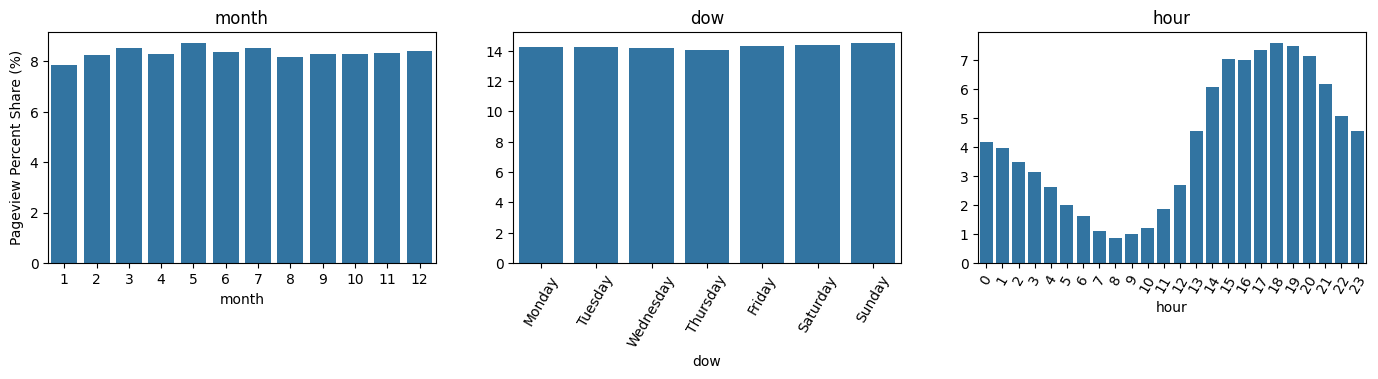

In [24]:
fig, axs = plt.subplots(1,3, figsize=(17,3))

for i, group in enumerate(pv_time_groups):
  g = sns.barplot(data=time_pv_share[group], x=time_groups[i], y='pv_share (%)', ax=axs.flat[i])
  g.set_ylabel(None)
  g.set_title(time_groups[i])
  if time_groups[i] == 'month':
    g.set_ylabel('Pageview Percent Share (%)')
  if time_groups[i] != 'month':
    g.tick_params(axis='x', rotation=60)

#### **Pageviews via Segment** (Country, Region, Marketing, Device, Browser)

In [25]:
seg = ['country', 'device_type', 'browser_type', 'region', 'marketing_source']
pv_share = {}
for x in range(len(seg)):
  pv_share["{0}_pv".format(seg[x])] = pv_df.groupby(seg[x])['pageview_id'].count().reset_index().sort_values('pageview_id', ascending=False)
  tot_pv = pv_share["{0}_pv".format(seg[x])]['pageview_id'].sum()
  pv_share["{0}_pv".format(seg[x])]['pv_share (%)'] = round(pv_share["{0}_pv".format(seg[x])]['pageview_id']/tot_pv*100, 2)
  pv_share["{0}_pv".format(seg[x])].rename(columns={'pageview_id': 'n_pageviews'}, inplace=True)
pv_groups = list(pv_share.keys())

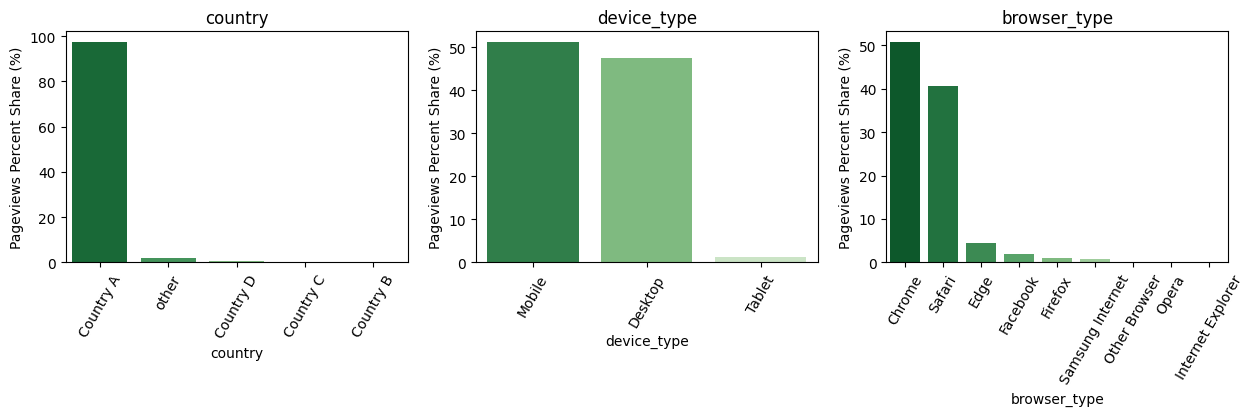

In [26]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

for i, group in enumerate(pv_groups[:3]):
  if len(pv_share[group][seg[i]]) < 11:
    g = sns.barplot(data=pv_share[group], x=seg[i], y='pv_share (%)', palette='Greens_r', ax=axs.flat[i])
    g.set_ylabel('Pageviews Percent Share (%)')
    g.tick_params(axis='x', rotation=60)
  g.set_title(seg[i])

Text(0.5, 1.0, 'Marketing Source')

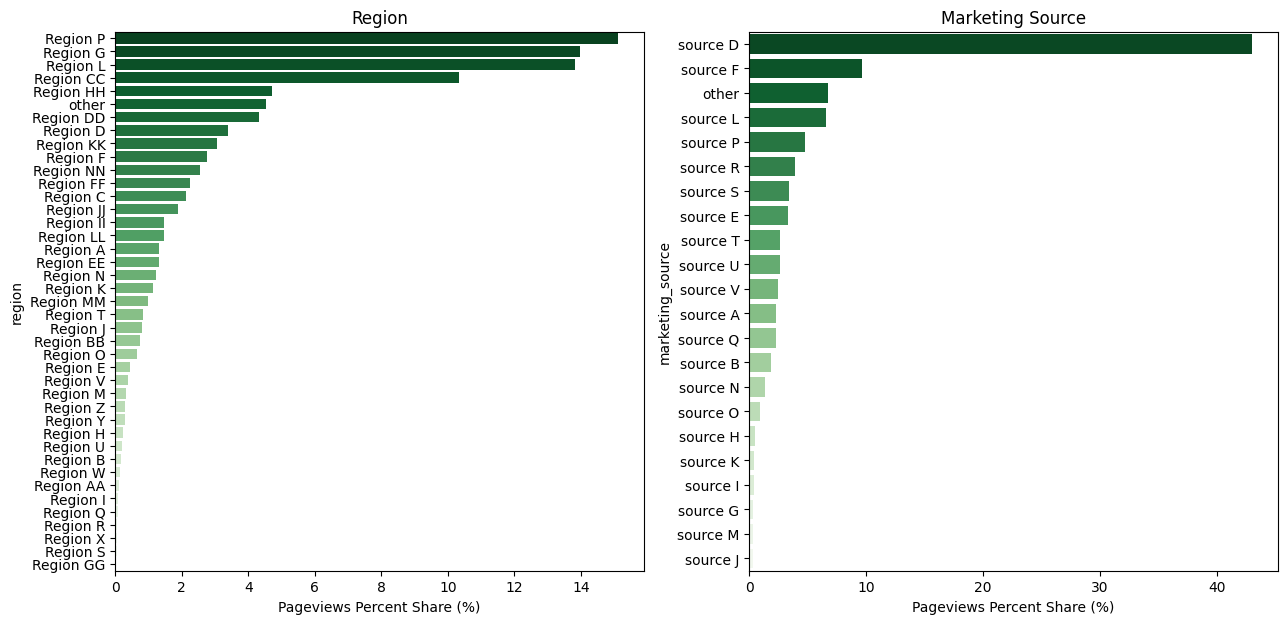

In [27]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
g = sns.barplot(data=pv_share['region_pv'], x='pv_share (%)', y='region', orient='h', palette='Greens_r', ax=axs.flat[0])
h = sns.barplot(data=pv_share['marketing_source_pv'], x='pv_share (%)', y='marketing_source', orient='h', palette='Greens_r', ax=axs.flat[1])
g.set_xlabel('Pageviews Percent Share (%)')
h.set_xlabel('Pageviews Percent Share (%)')
g.set_title('Region')
h.set_title('Marketing Source')

#### **Session Duration via Time**

In [28]:
pv_df_sd = outlier_removal(pv_df, 'session_duration')

In [29]:
time_groups = ['month', 'dow', 'hour']
time_sd_pv = {}
for x in range(len(time_groups)):
  time_sd_pv["{0}_sd_pv".format(time_groups[x])] = pv_df_sd.groupby(time_groups[x])['session_duration'].mean().reset_index()
  if time_groups[x] == 'dow':
    time_sd_pv["{0}_sd_pv".format(time_groups[x])]['dow'] = time_sd_pv["{0}_sd_pv".format(time_groups[x])]['dow'].astype(int)
    time_sd_pv["{0}_sd_pv".format(time_groups[x])]['dow'] = time_sd_pv["{0}_sd_pv".format(time_groups[x])]['dow'].apply(lambda x: cal.day_name[x])
sd_pv_time_groups = list(time_sd_pv.keys())

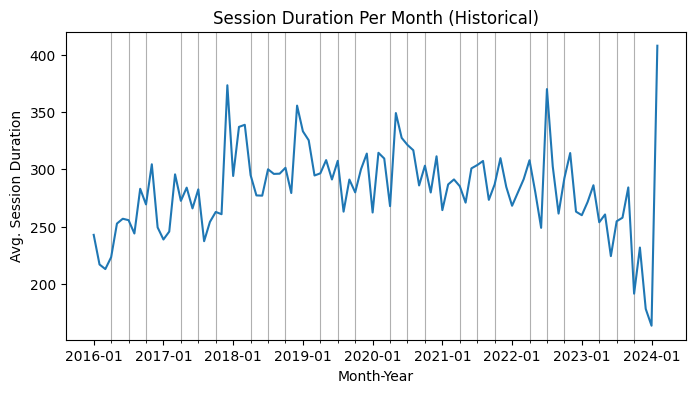

In [30]:
sdm_pv = pv_df_sd.groupby('month_year')['session_duration'].mean().reset_index()

plt.figure(figsize=(8, 4))
g = sns.lineplot(sdm_pv, x='month_year', y='session_duration')
plt.xlabel('Month-Year')
plt.ylabel('Avg. Session Duration')
plt.title('Session Duration Per Month (Historical)')
g.set_xticks(qtr, minor=True)
g.set_xticks(years, minor=False)
g.xaxis.grid(True, which='minor')
g.xaxis.grid(False, which='major')
# g.legend().set_visible(False)
plt.show()

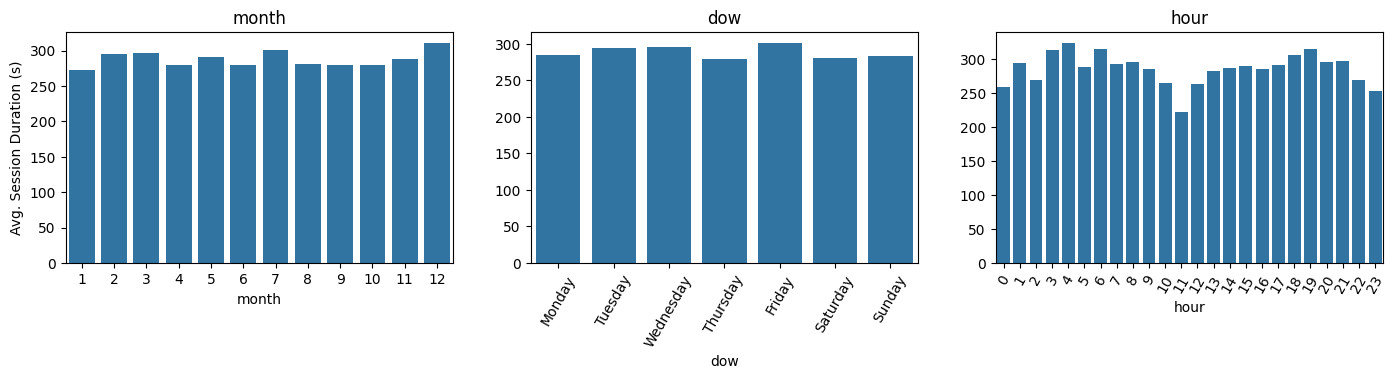

In [31]:
fig, axs = plt.subplots(1,3, figsize=(17,3))

for i, group in enumerate(sd_pv_time_groups):
  g = sns.barplot(data=time_sd_pv[group], x=time_groups[i], y='session_duration', ax=axs.flat[i])
  g.set_ylabel(None)
  if time_groups[i] == 'month':
    g.set_ylabel('Avg. Session Duration (s)')
  if time_groups[i] != 'month':
    g.tick_params(axis='x', rotation=60)
  g.set_title(time_groups[i])

#### **Session Duration via Segment**

In [32]:
seg = ['country', 'device_type', 'browser_type', 'region', 'marketing_source']
sd_pv_avg = {}
for x in range(len(seg)):
  sd_pv_avg["{0}_sd_pv".format(seg[x])] = pv_df_sd.groupby(seg[x])['session_duration'].mean().reset_index().sort_values('session_duration', ascending=False)
sd_pv_groups = list(sd_pv_avg.keys())

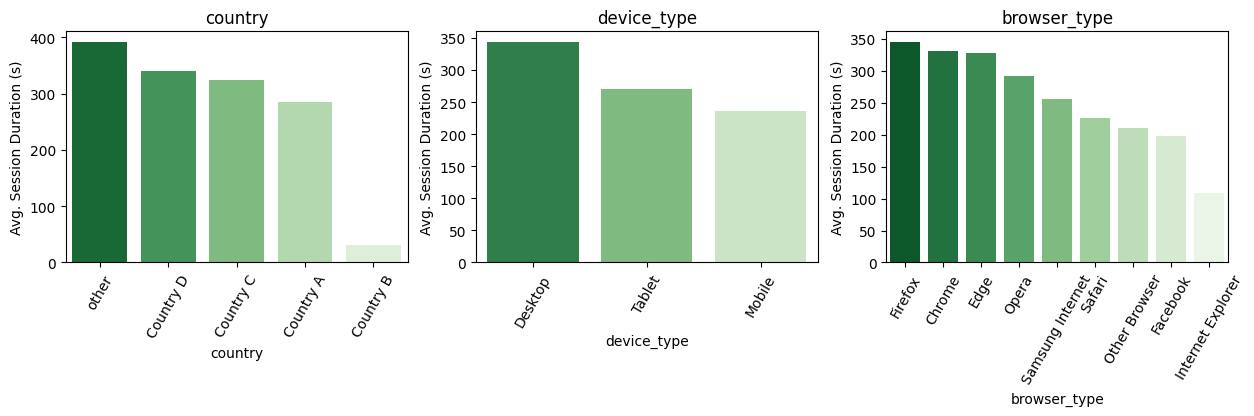

In [33]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

for i, group in enumerate(sd_pv_groups[:3]):
  if len(sd_pv_avg[group][seg[i]]) < 11:
    g = sns.barplot(data=sd_pv_avg[group], x=seg[i], y='session_duration', palette='Greens_r', ax=axs.flat[i])
    g.set_ylabel('Avg. Session Duration (s)')
    g.tick_params(axis='x', rotation=60)
  g.set_title(seg[i])

Text(0.5, 1.0, 'Marketing Source')

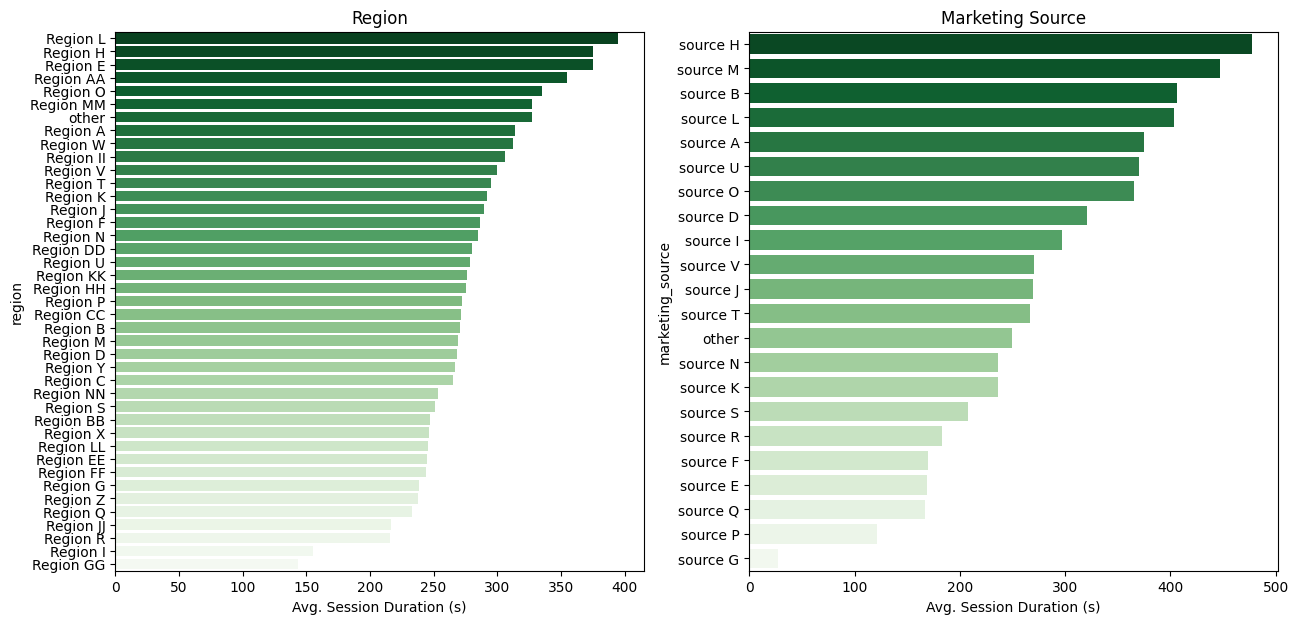

In [34]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
g = sns.barplot(data=sd_pv_avg['region_sd_pv'], x='session_duration', y='region', orient='h', palette='Greens_r', ax=axs.flat[0])
h = sns.barplot(data=sd_pv_avg['marketing_source_sd_pv'], x='session_duration', y='marketing_source', orient='h', palette='Greens_r', ax=axs.flat[1])
g.set_xlabel('Avg. Session Duration (s)')
h.set_xlabel('Avg. Session Duration (s)')
g.set_title('Region')
h.set_title('Marketing Source')

### Funnel Table

In [35]:
from plotly import graph_objects as go
stages = {'cart1':'first_cart_item_ts', 'pur1':'first_purchase_ts', 'pur2':'second_purchase_ts'}
funnel_seg = {'fos':'frequency_of_online_shopping','st':'shoe_type','pfu':'primary_footwear_use','sp':'shipping_preference','es':'eligible_for_express_shipping'}

In [36]:
# Issue with looping
conv_dfs = {}
for i, x in enumerate(stages):
  conv_dfs["{0}_funnel".format(list(stages.keys())[i])] = funnel_df.groupby('frequency_of_online_shopping')[list(stages.values())[i]].count().reset_index()
  conv_dfs["{0}_funnel".format(list(stages.keys())[i])] = pd.melt(conv_dfs["{0}_funnel".format(list(stages.keys())[i])], id_vars=['frequency_of_online_shopping'],value_vars=[list(stages.values())[i]])
dfs = list(conv_dfs.keys())
conv_fos = pd.concat([conv_dfs[dfs[0]], conv_dfs[dfs[1]], conv_dfs[dfs[2]]], axis=0)

conv_dfs = {}
for i, x in enumerate(stages):
  conv_dfs["{0}_funnel".format(list(stages.keys())[i])] = funnel_df.groupby('shoe_type')[list(stages.values())[i]].count().reset_index()
  conv_dfs["{0}_funnel".format(list(stages.keys())[i])] = pd.melt(conv_dfs["{0}_funnel".format(list(stages.keys())[i])], id_vars=['shoe_type'],value_vars=[list(stages.values())[i]])
dfs = list(conv_dfs.keys())
conv_st = pd.concat([conv_dfs[dfs[0]], conv_dfs[dfs[1]], conv_dfs[dfs[2]]], axis=0)

conv_dfs = {}
for i, x in enumerate(stages):
  conv_dfs["{0}_funnel".format(list(stages.keys())[i])] = funnel_df.groupby('primary_footwear_use')[list(stages.values())[i]].count().reset_index()
  conv_dfs["{0}_funnel".format(list(stages.keys())[i])] = pd.melt(conv_dfs["{0}_funnel".format(list(stages.keys())[i])], id_vars=['primary_footwear_use'],value_vars=[list(stages.values())[i]])
dfs = list(conv_dfs.keys())
conv_pfu = pd.concat([conv_dfs[dfs[0]], conv_dfs[dfs[1]], conv_dfs[dfs[2]]], axis=0)

conv_dfs = {}
for i, x in enumerate(stages):
  conv_dfs["{0}_funnel".format(list(stages.keys())[i])] = funnel_df.groupby('shipping_preference')[list(stages.values())[i]].count().reset_index()
  conv_dfs["{0}_funnel".format(list(stages.keys())[i])] = pd.melt(conv_dfs["{0}_funnel".format(list(stages.keys())[i])], id_vars=['shipping_preference'],value_vars=[list(stages.values())[i]])
dfs = list(conv_dfs.keys())
conv_sp = pd.concat([conv_dfs[dfs[0]], conv_dfs[dfs[1]], conv_dfs[dfs[2]]], axis=0)

conv_dfs = {}
for i, x in enumerate(stages):
  conv_dfs["{0}_funnel".format(list(stages.keys())[i])] = funnel_df.groupby('eligible_for_express_shipping')[list(stages.values())[i]].count().reset_index()
  conv_dfs["{0}_funnel".format(list(stages.keys())[i])] = pd.melt(conv_dfs["{0}_funnel".format(list(stages.keys())[i])], id_vars=['eligible_for_express_shipping'],value_vars=[list(stages.values())[i]])
dfs = list(conv_dfs.keys())
conv_es = pd.concat([conv_dfs[dfs[0]], conv_dfs[dfs[1]], conv_dfs[dfs[2]]], axis=0)


In [37]:
stage_names = list(stages.values())
conv = []
for i in range(len(stage_names)):
  conv.append(funnel_df[stage_names[i]].count())

tot_cr = dict(numbers=conv, funnel=stages)
fig = go.Figure(go.Funnel(y=stage_names, x=conv, textposition= 'inside', textinfo='value+percent previous+percent initial',
                          marker = {"color": ["deepskyblue", "lightsalmon", "teal"]}))

fig.update_layout(
    title="Overall",
    xaxis_title="Conversion Rate",
    yaxis_title="Stage")

fig.show()

In [38]:
freq_x = list(conv_fos.loc[conv_fos['frequency_of_online_shopping'] == 'frequently']['value'])
rare_x = list(conv_fos.loc[conv_fos['frequency_of_online_shopping'] == 'rarely']['value'])
some_x = list(conv_fos.loc[conv_fos['frequency_of_online_shopping'] == 'sometimes']['value'])

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'frequently',
    y = list(stages.values()),
    x = freq_x,
    textinfo='value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = 'rarely',
    y = list(stages.values()),
    x = rare_x,
    textinfo='value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = 'sometimes',
    y = list(stages.values()),
    x = some_x,
    textinfo='value+percent previous+percent initial'))

fig.update_layout(
    title="Frequency of Online Shopping",
    xaxis_title="Conversion Rate",
    yaxis_title="Stage")

fig.show()

In [39]:
boot_x = list(conv_st.loc[conv_st['shoe_type'] == 'boots']['value'])
flat_x = list(conv_st.loc[conv_st['shoe_type'] == 'flats']['value'])
sand_x = list(conv_st.loc[conv_st['shoe_type'] == 'sandals']['value'])
sneak_x = list(conv_st.loc[conv_st['shoe_type'] == 'sneakers']['value'])

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'boots',
    y = list(stages.values()),
    x = boot_x,
    textinfo='value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = 'flats',
    y = list(stages.values()),
    x = flat_x,
    textinfo='value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = 'sandals',
    y = list(stages.values()),
    x = sand_x,
    textinfo='value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = 'sneakers',
    y = list(stages.values()),
    x = sneak_x,
    textinfo='value+percent previous+percent initial'))

fig.update_layout(
    title="Shoe Type",
    xaxis_title="Conversion Rate",
    yaxis_title="Stage")

fig.show()

In [40]:
cw_x = list(conv_pfu.loc[conv_pfu['primary_footwear_use'] == 'casual_wear']['value'])
fit_x = list(conv_pfu.loc[conv_pfu['primary_footwear_use'] == 'fitness']['value'])
work_x = list(conv_pfu.loc[conv_pfu['primary_footwear_use'] == 'work']['value'])


fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'casual_wear',
    y = list(stages.values()),
    x = cw_x,
    textinfo='value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = 'fitness',
    y = list(stages.values()),
    x = fit_x,
    textinfo='value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = 'work',
    y = list(stages.values()),
    x = work_x,
    textinfo='value+percent previous+percent initial'))

fig.update_layout(
    title="Primary Footwear Use",
    xaxis_title="Conversion Rate",
    yaxis_title="Stage")

fig.show()

In [41]:
dm_x = list(conv_sp.loc[conv_sp['shipping_preference'] == 'doesnt_matter']['value'])
ex_x = list(conv_sp.loc[conv_sp['shipping_preference'] == 'express_overnight']['value'])
free_x = list(conv_sp.loc[conv_sp['shipping_preference'] == 'free_ground_shipping']['value'])
pu_x = list(conv_sp.loc[conv_sp['shipping_preference'] == 'in_store_pickup']['value'])

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'doesnt_matter',
    y = list(stages.values()),
    x = dm_x,
    textinfo='value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = 'express_overnight',
    y = list(stages.values()),
    x = ex_x,
    textinfo='value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = 'free_ground_shipping',
    y = list(stages.values()),
    x = free_x,
    textinfo='value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = 'in_store_pickup',
    y = list(stages.values()),
    x = pu_x,
    textinfo='value+percent previous+percent initial'))

fig.update_layout(
    title="Shipping Preference",
    xaxis_title="Conversion Rate",
    yaxis_title="Stage")

fig.show()

In [42]:
no_x = list(conv_es.loc[conv_es['eligible_for_express_shipping'] == 0]['value'])
yes_x = list(conv_es.loc[conv_es['eligible_for_express_shipping'] == 1]['value'])

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Not eligible',
    y = list(stages.values()),
    x = no_x,
    textinfo='value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = 'Eligible',
    y = list(stages.values()),
    x = yes_x,
    textinfo='value+percent previous+percent initial'))

fig.update_layout(
    title="Eligibility for Express Shipping",
    xaxis_title="Conversion Rate",
    yaxis_title="Stage")

fig.show()

### **Metrics + Calculations**

In [43]:
pv_share['country_pv'].head()
sd_pv_avg['country_sd_pv'].head()

,country,session_duration
4,other,391.230453
3,Country D,340.423808
2,Country C,324.566790
0,Country A,285.630387
1,Country B,30.634600


In [44]:
pv_share['device_type_pv'].head()
sd_pv_avg['device_type_sd_pv'].head()

,device_type,session_duration
0,Desktop,343.101430
2,Tablet,270.058704
1,Mobile,235.452140


In [45]:
pv_share['browser_type_pv'].head()
sd_pv_avg['browser_type_sd_pv']

,browser_type,session_duration
3,Firefox,344.712722
0,Chrome,331.278034
1,Edge,328.896212
5,Opera,291.918619
8,Samsung Internet,256.177857
7,Safari,226.086499
6,Other Browser,210.306237
2,Facebook,197.526713
4,Internet Explorer,108.122655


In [46]:
pv_share['region_pv'].head()
sd_pv_avg['region_sd_pv'].head()

,region,session_duration
22,Region L,395.074704
14,Region H,375.427322
8,Region E,375.154682
1,Region AA,354.983097
28,Region O,335.245027


In [47]:
pv_share['marketing_source_pv'].head()
sd_pv_avg['marketing_source_sd_pv'].head()

,marketing_source,session_duration
7,source H,477.945426
12,source M,446.772527
2,source B,406.710094
11,source L,403.337025
1,source A,375.071025


In [48]:
sdm_pv.sort_values('session_duration',ascending=False).head()

,month_year,session_duration
97,2024-02,407.962029
23,2017-12,373.437161
78,2022-07,370.100680
35,2018-12,355.656237
52,2020-05,349.155432


In [49]:
pv_df['timestamp'].max()

Timestamp('2024-02-12 03:05:17.817000+0000', tz='UTC')

##### **Session Duration**
* AVG (Session End Time - Session Start Time)

In [50]:
pv_df_sd = outlier_removal(pv_df, 'session_duration')
avg_SD = pv_df_sd['session_duration'].mean()
print(f"Average Session Duration: {avg_SD:.2f} seconds | {avg_SD/60:.2f} mins")

Average Session Duration: 288.12 seconds | 4.80 mins


##### **Pageviews Per Month + 2023 Calculation**

In [51]:
avg_month_pv = monthly_pv['n_pageviews'].mean()
pv_2023 = pv_df.loc[pv_df['timestamp'].dt.year == 2023,:]
monthly_pv_2023 = pv_2023.groupby('month_year')['pageview_id'].count().reset_index()
monthly_pv_2023.rename(columns={'pageview_id': 'n_pageviews'}, inplace=True)
avg_month_pv_2023 = monthly_pv_2023['n_pageviews'].mean()
avg_decr_2023 = (avg_month_pv - avg_month_pv_2023)/avg_month_pv * 100
print(f"Monthly Average Pageviews: {avg_month_pv:.1f} views")
print(f"Monthly Average Pageviews (2023): {avg_month_pv_2023:.1f} views")
print(f"Percentage Decrease in monthly pageviews from historical average in 2023: {avg_decr_2023:.1f} %")

Monthly Average Pageviews: 3915.7 views
Monthly Average Pageviews (2023): 2022.2 views
Percentage Decrease in monthly pageviews from historical average in 2023: 48.4 %


##### **Hourly PV calculations**

In [52]:
avg_hour_pct = time_pv_share['hour_pv']['pv_share (%)'].mean()
avg_hour_pct_peak = time_pv_share['hour_pv'].loc[time_pv_share['hour_pv']['hour'].between(15,21)]['pv_share (%)'].mean()
avg_hour_peak_incr = (avg_hour_pct_peak - avg_hour_pct)
print(f"Average PV Percent Share by Hour: {avg_hour_pct:.2f} %")
print(f"Peak Hours Average PV Percent Share (3PM - 9PM): {avg_hour_pct_peak:.2f} %")
print(f"Percentage Increase from Peak Hours to Hourly Average: {avg_hour_peak_incr:.2f} %")

Average PV Percent Share by Hour: 4.17 %
Peak Hours Average PV Percent Share (3PM - 9PM): 7.13 %
Percentage Increase from Peak Hours to Hourly Average: 2.96 %


In [53]:
avg_hour_sd = time_sd_pv['hour_sd_pv']['session_duration'].mean()
avg_hour_sd_peak = time_sd_pv['hour_sd_pv'].loc[time_sd_pv['hour_sd_pv']['hour'].between(9,13)]['session_duration'].mean()
avg_hour_peak_decr = (avg_hour_sd - avg_hour_sd_peak)
print(f"Average Session Duration by Hour: {avg_hour_sd:.2f} (s)")
print(f"Dip Hours Average Session Duration (10AM - 12PM): {avg_hour_sd_peak:.2f} (s)")
print(f"Average Session Duration Decrease (Hourly Average, Dip): {avg_hour_peak_decr:.2f} (s)")

Average Session Duration by Hour: 285.57 (s)
Dip Hours Average Session Duration (10AM - 12PM): 263.39 (s)
Average Session Duration Decrease (Hourly Average, Dip): 22.18 (s)


In [54]:
time_pv_share['hour_pv']
time_sd_pv['hour_sd_pv']

,hour,session_duration
0,0,259.073925
1,1,293.574959
2,2,268.896278
3,3,313.466269
4,4,323.339885
5,5,288.287740
6,6,315.085854
7,7,293.085217
8,8,294.983445
9,9,285.686422


### **Conversion Metrics**

##### **Conversion Rate**
* % of prospective customers who progress through the sales funnel and make a 'first-time purchase'
* Total First Time Purchases / Total Unique Customers * 100


In [55]:
# Calculate conversion rate
total_customers = funnel_df['customer_id'].nunique()
total_purchases = funnel_df.loc[funnel_df['first_purchase_ts'].notnull(), 'customer_id'].nunique()
cp_conversion_rate = (total_purchases / total_customers) * 100

# Display conversion rate
print(f"Customer - Purchase Conversion Rate: {cp_conversion_rate:.2f}%")

Customer - Purchase Conversion Rate: 58.64%


##### **Cart to Purchase Duration**
* AVG (First Purchase Timestamp - First Carting Item Timestamp)

In [56]:
# Avg Time Between First Cart Item to First Purchase
FCTP = outlier_removal(funnel_df, 'cart_to_purchase_duration')
avg_FCTP = FCTP['cart_to_purchase_duration'].mean()/60/60
print(f"Average Cart To Purchase Duration: {avg_FCTP:.1f} hours | {avg_FCTP/24:.1f} days")

Average Cart To Purchase Duration: 22.0 hours | 0.9 days


### **Retention Metrics**

##### **Return Purchase Rate**
* % of customers who make a second purchase after their first purchase
* Second Purchase Customers / Total Unique Customers * 100

In [57]:
second_purchase_customers = funnel_df.loc[funnel_df['second_purchase_ts'].notna(), 'customer_id'].nunique()
RPR = (second_purchase_customers/total_customers) * 100
print(f"Return Purchase Rate: {RPR:.2f}%")

Return Purchase Rate: 37.97%


##### **First to Second Purchase Duration**
* Average time interval between a customer's first and second purchase
* AVG (Second Purchase Timestamp - First Purchase Timestamp)

In [58]:
# Avg Time Between First to Second Purchase
FTSP = outlier_removal(funnel_df, 'first_to_second_purchase')
avg_FTSP = funnel_df['first_to_second_purchase'].mean()/60/60
print(f"Average Time Between First To Second Purchase: {avg_FTSP:.1f} hours | {avg_FTSP/24:.1f} days")

Average Time Between First To Second Purchase: 290.7 hours | 12.1 days


## **Final Thoughts**

**Clarifying Questions:**
* Is every customer in funnel table accounted for in pageviews table?
* Is there a relationship between both tables, if so on what features/columns?
* How is a website_visitor_id defined? session_id?
* Data source of both table?
* Define a 'high-quality customer' ?

**Future Resources:**
* Pricing data for revenue-related metrics (AOV, CLV, CAC)
* Start/End Session Timestamps for time spent metrics
* Top Landing Pages

Relying solely on IP addresses for correlation can indeed be risky due to several factors:

Shared IP Addresses: Multiple users may share the same IP address, especially in corporate environments or public Wi-Fi networks. In such cases, correlating based on IP address alone could lead to inaccuracies or mismatches.

Dynamic IP Assignment: Many ISPs assign dynamic IP addresses to users, meaning the IP address can change over time or between sessions. This makes it challenging to reliably link visitors to customers based on IP address alone.